In [1]:
import pandas as pd  
import numpy as np     
import matplotlib.pyplot as plt  
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image   
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\comp

# Image Captioning
Generating Captions for Images

# Steps
Data collection

Understanding the data

Data Cleaning

Loading the training set

Data Preprocessing — Images

Data Preprocessing — Captions

Data Preparation using Generator Function

Word Embeddings

Model Architecture

Inference

In [2]:

# Read Text Captions

def readTextFile(path):
    with open(path) as f:   # best way to close a file "with " use krke 
        captions = f.read()   #The read() method returns the specified number of bytes(parameter which is optional) from the file. Default is -1 which means the whole file.
    return captions

In [3]:
captions  = readTextFile("Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")   #to
#print(captions)    ye krne se problem ..  file is too large isliye saare captions nahi read ho paa rhe so lets print some of the captions 
#len(captions.split('\n')[:-1])    # captions.split('\n') - split everything abt new line character  
                                   # 
captions = captions.split('\n')[:-1]  #discard last line as its empty

In [4]:
captions[0].split('\t')  #ye krne se ek list milta h 1st ele is img id concatinate with cap id and 2nd ele is caption

first,second  = captions[0].split('\t')
print(first.split(".")[0])   # .jpg wala cheez hatane k iye nd 0th ele extract krne ko
print(second)   #ye description h

1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


In [5]:
# Dictionary to Map each Image with the list of captions it has

descriptions = {}

for x in captions:   #iterate over all elements 
    first,second = x.split('\t')
    img_name = first.split(".")[0]
    
    #if the image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []  #map it with a key which is a list
    
    descriptions[img_name].append(second)  #if the list is aready present 

In [6]:
descriptions["1000268201_693b08cb0e"]  #img id de diya 

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

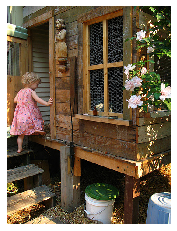

In [7]:
#agar image read krni ho 
IMG_PATH = "Flickr_Data/Flickr_Data/Images/"
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #cv2 me rgm me rehta h by default

plt.imshow(img)
plt.axis("off")    # x and y pe jo values h usko hatae k liye 
plt.show()

# Data Cleaning

In [8]:
def clean_text(sentence):
    sentence = sentence.lower()
    #regular exp
    sentence = re.sub("[^a-z]+"," ",sentence)  # substitute anything which is not an alphabet ... one or more occurence of preceeding character .. replace by a space
    sentence = sentence.split()   #splits the string into a list
    
    sentence  = [s for s in sentence if len(s)>1]   #remove all the words with a len<=1  ...'a' remove .. numbers removed 
    sentence = " ".join(sentence)
    return sentence

In [9]:
clean_text("A cat is sitting over the house # 64")

'cat is sitting over the house'

In [10]:

# Clean all Captions      call this func for all elements in dictionay
for key,caption_list in descriptions.items():   #.itrm() se we iterate over all the key value pairs
    for i in range(len(caption_list)):   #iterate over all the cptions in a particular image 
        caption_list[i] = clean_text(caption_list[i])

In [11]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [12]:

# Write the data to text file

with open("descriptions_1.txt","w") as f:   # write mode ..  
    f.write(str(descriptions))

In [13]:
#i want to read all descriptions that i have storred in my file .. i dont know yet so..
descriptions = None
with open("descriptions_1.txt",'r') as f:
    descriptions= f.read()
    
    
    
json_acceptable_string = descriptions.replace("'","\"")   # replaced single quotes with backslash
#this lirary interprets as a json file and converts into python dict
descriptions = json.loads(json_acceptable_string)   


#string in a json ready format

In [14]:
print(type(descriptions))

<class 'dict'>


In [15]:
# Vocab

vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]   # inserting all the words in vocab... this will return a list
    
print("Vocab Size : %d"% len(vocab))

Vocab Size : 8424


In [16]:
vocab = set()
vocab.update(["hello","mango"])
vocab.update(["hi"])
print(vocab)

{'hi', 'mango', 'hello'}


In [17]:
# Total No of words across all the sentences
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]   
    
print("Total Words %d"%len(total_words))

Total Words 373837


In [18]:
# Filter Words from the Vocab according to certain threshold frequncy

In [19]:
import collections
#Collections in Python are containers that are used to store collections of data, for example, list, dict, set, tuple etc. These are built-in collections. Several modules have been developed that provide additional data structures to store collections of data. One such module is the Python collections module.

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(freq_cnt)    #this shows how many times a particular word is going to come 



{'child': 1545, 'in': 18987, 'pink': 739, 'dress': 348, 'is': 9345, 'climbing': 507, 'up': 1302, 'set': 109, 'of': 6723, 'stairs': 109, 'an': 2432, 'entry': 1, 'way': 53, 'girl': 3328, 'going': 149, 'into': 1074, 'wooden': 284, 'building': 511, 'little': 1768, 'playhouse': 6, 'the': 18420, 'to': 3176, 'her': 1178, 'cabin': 4, 'black': 3848, 'dog': 8138, 'and': 8863, 'spotted': 38, 'are': 3505, 'fighting': 133, 'tri': 14, 'colored': 221, 'playing': 2008, 'with': 7765, 'each': 430, 'other': 773, 'on': 10746, 'road': 398, 'white': 3959, 'brown': 2578, 'spots': 29, 'staring': 57, 'at': 2916, 'street': 944, 'two': 5643, 'dogs': 2125, 'different': 46, 'breeds': 5, 'looking': 744, 'pavement': 48, 'moving': 41, 'toward': 146, 'covered': 372, 'paint': 62, 'sits': 577, 'front': 1386, 'painted': 64, 'rainbow': 22, 'hands': 246, 'bowl': 30, 'sitting': 1368, 'large': 1237, 'small': 1278, 'grass': 1622, 'plays': 526, 'fingerpaints': 3, 'canvas': 6, 'it': 401, 'there': 304, 'pigtails': 14, 'painting'

In [20]:
print(len(freq_cnt.keys()))   #same as no. of unique words

8424


In [21]:
# Sort this dictionary according to the freq count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])  #sortd func operates on a list .. so .items kia h .. it gives a list of items of dict freq_cnt

# Filter
threshold = 10
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]    # x is tuple containing words and freq .. so x[0] will be the word 

In [22]:
sorted_freq_cnt

[('in', 18987),
 ('the', 18420),
 ('on', 10746),
 ('is', 9345),
 ('and', 8863),
 ('dog', 8138),
 ('with', 7765),
 ('man', 7275),
 ('of', 6723),
 ('two', 5643),
 ('white', 3959),
 ('black', 3848),
 ('boy', 3581),
 ('are', 3505),
 ('woman', 3403),
 ('girl', 3328),
 ('to', 3176),
 ('wearing', 3062),
 ('at', 2916),
 ('people', 2887),
 ('water', 2790),
 ('red', 2691),
 ('young', 2630),
 ('brown', 2578),
 ('an', 2432),
 ('his', 2357),
 ('blue', 2279),
 ('dogs', 2125),
 ('running', 2073),
 ('through', 2032),
 ('playing', 2008),
 ('while', 1968),
 ('shirt', 1962),
 ('down', 1843),
 ('standing', 1789),
 ('ball', 1783),
 ('little', 1768),
 ('grass', 1622),
 ('snow', 1547),
 ('child', 1545),
 ('person', 1542),
 ('jumping', 1473),
 ('over', 1415),
 ('three', 1389),
 ('front', 1386),
 ('sitting', 1368),
 ('holding', 1324),
 ('up', 1302),
 ('field', 1283),
 ('small', 1278),
 ('by', 1249),
 ('large', 1237),
 ('green', 1234),
 ('one', 1223),
 ('group', 1218),
 ('yellow', 1217),
 ('her', 1178),
 ('walk

In [23]:
total_words    # a list 
len(total_words)

1845

# Prepare Train/Test Data

In [24]:
train_file_data = readTextFile("Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [25]:
#print(train_file_data)    #string
#train_file_data[-1]     # last row is null

In [26]:

train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]  #last row chor ke  as its null...  dot wala so as to remove the jpeg thing
#print(train)
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [27]:
train[:5]    # starting k 5

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [28]:

# Prepare Description for the Training Data


# Tweak - Add <s> and <e> token to our training data
train_descriptions = {}

for img_id in train:    # train is a list of img ID
    train_descriptions[img_id] = []   # iss list me caption add krne ka h
    for cap in descriptions[img_id]:
        cap_to_append = "startseq "  + cap + " endseq"   #isko training me add krna h
        train_descriptions[img_id].append(cap_to_append)

In [29]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

# Transfer Learning
Images --> Features


Text ---> Features

In [30]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))   # 3 becoz colored image hai
model.summary()


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [31]:
model.layers[-2]

In [32]:
model.layers[-2].output

# It will be tensor 
# Symboic tensor which means once we pass our data through this layer we get (?,2048) outputs
# ?-- no. of examples ...   2046 -- fixed vector for every image 

<tf.Tensor 'avg_pool/Mean:0' shape=(None, 2048) dtype=float32>

In [33]:
model_new = Model(model.input,model.layers[-2].output)    # this model is a part of keras functional API

In [34]:

def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))   #Loads an image into PIL format.
    img = image.img_to_array(img)        
    img = np.expand_dims(img,axis=0)  #Returns a tensor with a length 1 axis inserted at index axis.
    
    
    # Normalisation
    
    
    
    img = preprocess_input(img)    #
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


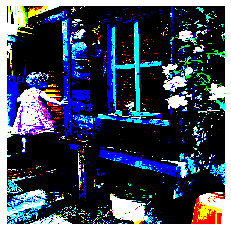

[[[[ -30.939003   -61.779      -67.68     ]
   [  13.060997     6.2210007  -17.68     ]
   [  34.060997    32.221        5.3199997]
   ...
   [ -99.939     -116.779     -118.68     ]
   [ -98.939     -111.779     -118.68     ]
   [-101.939     -108.779     -120.68     ]]

  [[ -36.939003   -68.779      -72.68     ]
   [  21.060997     9.221001   -13.68     ]
   [  38.060997    37.221        8.32     ]
   ...
   [ -94.939     -104.779     -113.68     ]
   [ -93.939     -108.779     -116.68     ]
   [ -90.939      -86.779     -102.68     ]]

  [[ -39.939003   -74.779      -76.68     ]
   [  26.060997    13.221001    -9.68     ]
   [  41.060997    36.221        6.3199997]
   ...
   [ -99.939     -107.779     -115.68     ]
   [-101.939     -107.779     -121.68     ]
   [ -95.939     -101.779     -123.68     ]]

  ...

  [[ -27.939003    56.221      107.32     ]
   [ -92.939      -49.779       20.32     ]
   [ -49.939003   -13.778999    35.32     ]
   ...
   [ 150.061      132.22101    126.

In [35]:
img = preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
plt.imshow(img[0])    # [0] because its  4D tensor 
plt.axis("off")
plt.show()
print(img)   #done by resnet 


#matplotlib is not howing it in a correct manner as it is percieved by resnet 

In [36]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    
    #print(feature_vector.shape)  # output : ( 1, 2048)
    feature_vector = feature_vector.reshape((-1,))
    
    #print(feature_vector.shape)  # output : (2048,)
    return feature_vector


In [37]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")   # gives values corresponding to the feature vector 

array([0.04154296, 0.1707608 , 0.29278603, ..., 0.05089604, 0.31322354,
       0.8600745 ], dtype=float32)

In [38]:
start = time()
encoding_train = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(train):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100==0:     #everytime we complete 100 images 
        print("Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start)





Encoding in Progress Time step 0 
Encoding in Progress Time step 100 
Encoding in Progress Time step 200 
Encoding in Progress Time step 300 
Encoding in Progress Time step 400 
Encoding in Progress Time step 500 
Encoding in Progress Time step 600 
Encoding in Progress Time step 700 
Encoding in Progress Time step 800 
Encoding in Progress Time step 900 
Encoding in Progress Time step 1000 
Encoding in Progress Time step 1100 
Encoding in Progress Time step 1200 
Encoding in Progress Time step 1300 
Encoding in Progress Time step 1400 
Encoding in Progress Time step 1500 
Encoding in Progress Time step 1600 
Encoding in Progress Time step 1700 
Encoding in Progress Time step 1800 
Encoding in Progress Time step 1900 
Encoding in Progress Time step 2000 
Encoding in Progress Time step 2100 
Encoding in Progress Time step 2200 
Encoding in Progress Time step 2300 
Encoding in Progress Time step 2400 
Encoding in Progress Time step 2500 
Encoding in Progress Time step 2600 
Encoding in P

In [39]:

!mkdir saved

A subdirectory or file saved already exists.


In [40]:
# Store everything to the disk 
with open("saved/encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)    # store , f=file pointer where i need to dump the file

In [41]:

start = time()
encoding_test = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Test Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken(test) :",end_t-start)

Test Encoding in Progress Time step 0 
Test Encoding in Progress Time step 100 
Test Encoding in Progress Time step 200 
Test Encoding in Progress Time step 300 
Test Encoding in Progress Time step 400 
Test Encoding in Progress Time step 500 
Test Encoding in Progress Time step 600 
Test Encoding in Progress Time step 700 
Test Encoding in Progress Time step 800 
Test Encoding in Progress Time step 900 
Total Time Taken(test) : 338.94658041000366


In [42]:
with open("saved/encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

# Data pre-processing for Captions

In [43]:
len(total_words)   #vocab of shortlisted words

1845

In [44]:

word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1   #i+1 because we will not use index zero 
    idx_to_word[i+1] = word

In [45]:
word_to_idx["dog"]
idx_to_word[1]

'in'

In [46]:
print(len(idx_to_word))   # we will get no. of words

1845


In [47]:

# Two special words   as these are not in dataset/vocab
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1   # 1 for index zero wala part 
print("Vocab Size",vocab_size)

Vocab Size 1848


In [48]:
# to find max len sentece so that we know how many times we need to enroll the RNN
max_len = 0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

35


# Data Loader (Generator)


In [49]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0    # n= how many items do we have in out current batch 
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]     #one hot vectors 
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]    # for next func call 
                    n=0

# Word Embeddings

In [50]:

f = open("8542_11957_bundle_archive/glove.6B.50d.txt",encoding='utf8')

In [51]:
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding

In [52]:
f.close()

In [53]:

embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [54]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [55]:

embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [56]:
#embedding_matrix[1847]

# Model Architecture

In [57]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [58]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [59]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [60]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [61]:
# Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [62]:

model.compile(loss='categorical_crossentropy',optimizer="adam")

# Training of Model

In [63]:


epochs = 10
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [64]:

def train():
    
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,number_pics_per_batch)   # generator instance
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('model_weights'+str(i)+'.h5')

In [65]:
train()

Epoch 1/1
2000/2000 [==============================] - 1213s 607ms/step - loss: 4.2915
Epoch 1/1
2000/2000 [==============================] - 1296s 648ms/step - loss: 3.5762
Epoch 1/1
2000/2000 [==============================] - 1229s 614ms/step - loss: 3.3170
Epoch 1/1
2000/2000 [==============================] - 985s 492ms/step - loss: 3.1616
Epoch 1/1
2000/2000 [==============================] - 980s 490ms/step - loss: 3.0496
Epoch 1/1
2000/2000 [==============================] - 997s 499ms/step - loss: 2.9624
Epoch 1/1
2000/2000 [==============================] - 956s 478ms/step - loss: 2.8951
Epoch 1/1
2000/2000 [==============================] - 961s 481ms/step - loss: 2.8396
Epoch 1/1
2000/2000 [==============================] - 971s 486ms/step - loss: 2.7949
Epoch 1/1
2000/2000 [==============================] - 970s 485ms/step - loss: 2.7553


In [66]:
#model = load_model('model_weights.h5')

# Predictions

In [67]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

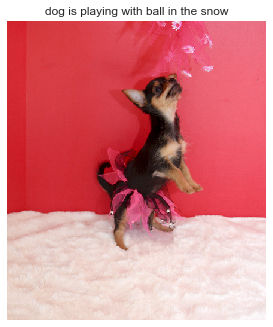

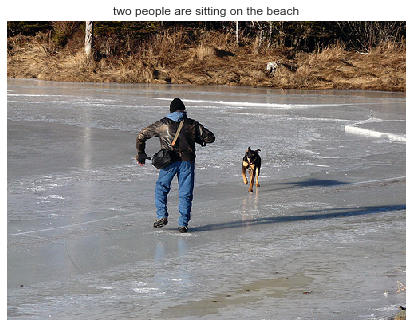

In [68]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(2):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("Flickr_Data/Flickr_Data/Images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

In [69]:
#encoding_test   # dic that maps image with feature vector